In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings 
warnings.filterwarnings('ignore')
from sklearn.metrics import accuracy_score
import seaborn as sns
import re
import pyodbc
import statsmodels.tsa.api as smt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import acf, pacf

C:\Users\v-asthana\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
cstrng = 'Driver={SQL Server},Server=AZ-PRD-SQ-WUW01,3000,Database=budget,trusted_connection=yes'   

v_driver = re.search('Driver=(.*),Server',cstrng).group(1)                              
v_server = re.search('Server=(.*),Database',cstrng).group(1)                              
v_database = re.search('Database=(.*),trusted',cstrng).group(1)                              
v_trusted = re.search('trusted_connection=(.*)',cstrng).group(1)

connection = pyodbc.connect(Driver=v_driver, 
                                    Server=v_server, 
                                    Database=v_database,
                                    trusted_connection=v_trusted)

In [27]:
sql = """select  dd.calendardate as Date, SUM(t.ProductSalesAmount) as Revenue 
        from (
        select  ProductSalesAmount, cast(LEFT(datedimkey,4)as varchar(4))+'-'+cast(right(LEFT(datedimkey,6),2)as varchar(2))+'-'+cast(right(datedimkey,2)as varchar(2)) as datedim
        from FunkoDataWarehouse.dbo.FactProductRevenue fp
        inner join FunkoDataWarehouse.[dbo].vwCustomerDim cd on fp.CustomerDimKey = cd.CustomerDimKey
        where fp.DateDimKey >=20140101 and fp.DateDimKey <20171101
        --and fp.ProductSalesAmount > 0 
        --and itemnumbersnk !='00002' 
        and fp.Intercompanyflag = 0
        --and cd.customernumbersnk not in ('C00443','C00444','C05058' ) 
         and (DateDimKey < 20170127 or (DateDimKey >= 20170127 and fp.Intercompanyflag = 0))
        and fp.CompanyDimKey =1
        and cd.CustomerType in ('B2B', 'UnKnown') 
        and fp.ETLIsDeleted = 0
        )t
        inner join FunkoDataWarehouse.dbo.DateDim dd on Cast(t.datedim as date)  >= dd.calendardate and  Cast(t.datedim as date)  < DATEADD(DD,7,calendardate)
        where dd.dayofweek = 1
        group by dd.CalendarDate
        order by dd.calendardate"""
df = pd.read_sql_query(sql,connection)

In [28]:
df['Date'] = pd.to_datetime(df['Date'],format="%Y-%m-%d")
df_w = df[1:]
df_w = df_w.set_index('Date')
#df_w = df_w[:-1]
df_w

,Revenue
Date,
2014-01-05,1042684.39
2014-01-12,1002286.50
2014-01-19,988924.54
2014-01-26,1159764.31
2014-02-02,476933.05
2014-02-09,587534.26
2014-02-16,1149108.62
2014-02-23,1293545.68
2014-03-02,643698.60


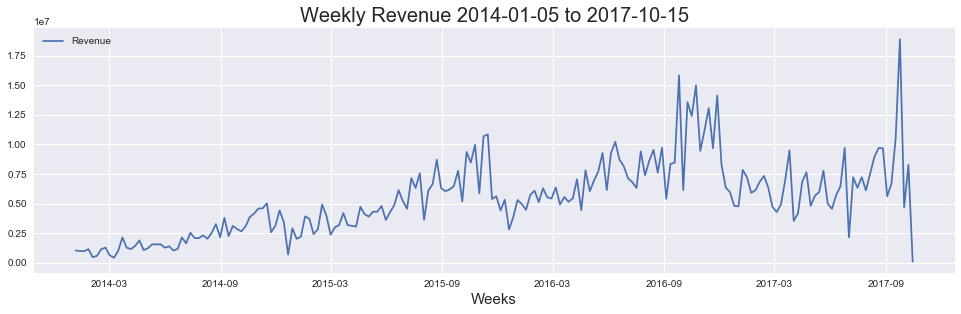

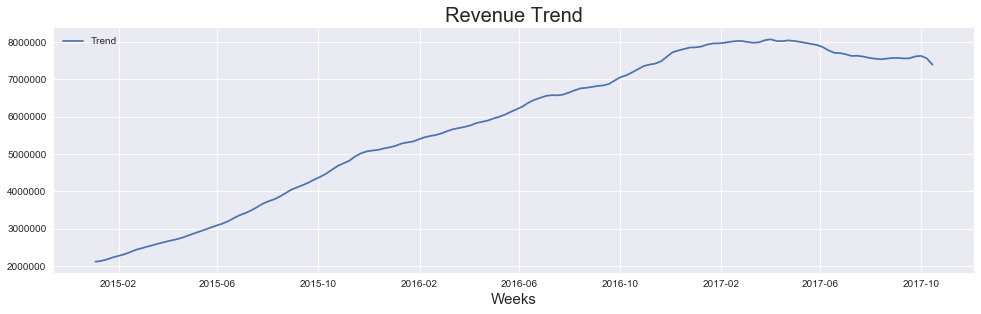

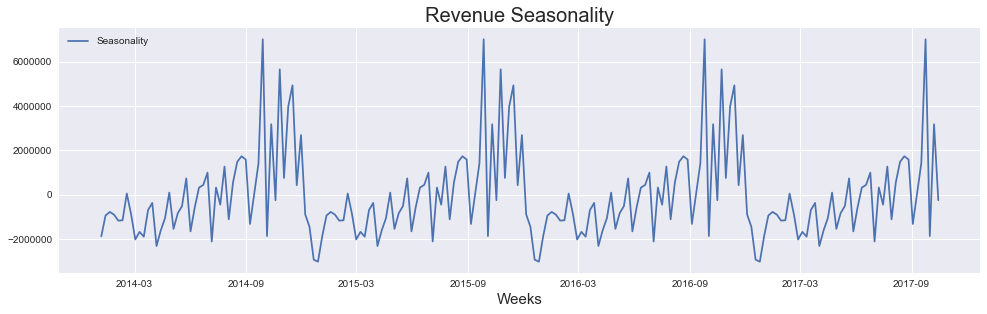

In [29]:
df_w  = df_w[['Revenue']]
plt.plot(df_w['Revenue'],label = 'Revenue')
plt.title('Weekly Revenue '+ str(df_w.index[0]).split(' ')[0] +' to '+ str(df_w.index[-1]).split(' ')[0],fontsize=20)
plt.xlabel('Weeks', fontsize=15)
plt.legend(loc='upper left')
fig = plt.gcf()
fig.set_size_inches(16.5, 4.5)
plt.show()
decomposition = seasonal_decompose(df_w,model='additive',two_sided = False,freq =52 )
trend = decomposition.trend
seasonal = decomposition.seasonal
resid = decomposition.resid
plt.plot(trend,label='Trend')
plt.xlabel('Weeks', fontsize=15)
plt.title('Revenue Trend',fontsize=20)
#plt.xticks(rotation=90)
plt.legend(loc='upper left')
fig = plt.gcf()
fig.set_size_inches(16.5, 4.5)
plt.show()
plt.plot(seasonal,label='Seasonality')
plt.xlabel('Weeks', fontsize=15)
plt.title('Revenue Seasonality',fontsize=20)
#plt.xticks(rotation=90)
plt.legend(loc='upper left')
fig = plt.gcf()
fig.set_size_inches(16.5, 4.5)
plt.show()

In [30]:
###### Adjusting Outliers #######
wnd = 5

df_w['RollingStd'] = df_w['Revenue'].rolling(window=wnd).std()
df_w['Rollingmean'] = df_w['Revenue'].rolling(window=wnd).mean()

st= df_w['RollingStd'][wnd]
mn= df_w['Rollingmean'][wnd]


for i in range(wnd+1,len(df_w)):
    if df_w['RollingStd'][i]-st > st:
        df_w['RollingStd'][i] = st*1.96
        df_w['Revenue'][i] = mn+st*1.96
        if mn > df_w['Rollingmean'][i]:
            df_w['Rollingmean'][i] = mn-st       
        else: 
            df_w['Rollingmean'][i] = mn+st
        st = df_w['RollingStd'][i]
        mn = df_w['Rollingmean'][i]
    else:
        st = df_w['RollingStd'][i]
        mn = df_w['Rollingmean'][i]
df_w

,Revenue,RollingStd,Rollingmean
Date,,,
2014-01-05,1.042684e+06,NaN,NaN
2014-01-12,1.002286e+06,NaN,NaN
2014-01-19,9.889245e+05,NaN,NaN
2014-01-26,1.159764e+06,NaN,NaN
2014-02-02,4.769330e+05,2.642781e+05,9.341186e+05
2014-02-09,5.875343e+05,2.942250e+05,8.430885e+05
2014-02-16,1.149109e+06,3.202602e+05,8.724530e+05
2014-02-23,1.293546e+06,3.726463e+05,9.333772e+05
2014-03-02,6.436986e+05,3.656702e+05,8.301640e+05


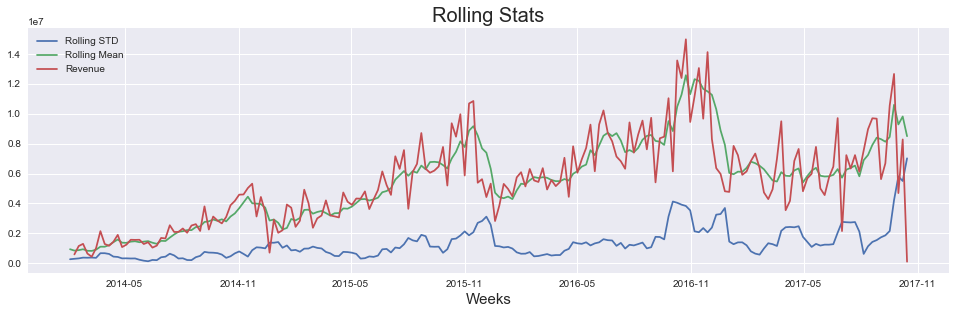

In [31]:
plt.plot(df_w['RollingStd'],label='Rolling STD')
plt.plot(df_w['Rollingmean'],label='Rolling Mean')
plt.plot(df_w['Revenue'][wnd:],label='Revenue')
plt.xlabel('Weeks', fontsize=15)
plt.title('Rolling Stats',fontsize=20)
#plt.xticks(rotation=90)
plt.legend(loc='upper left')
fig = plt.gcf()
fig.set_size_inches(16.5, 4.5)
plt.show()

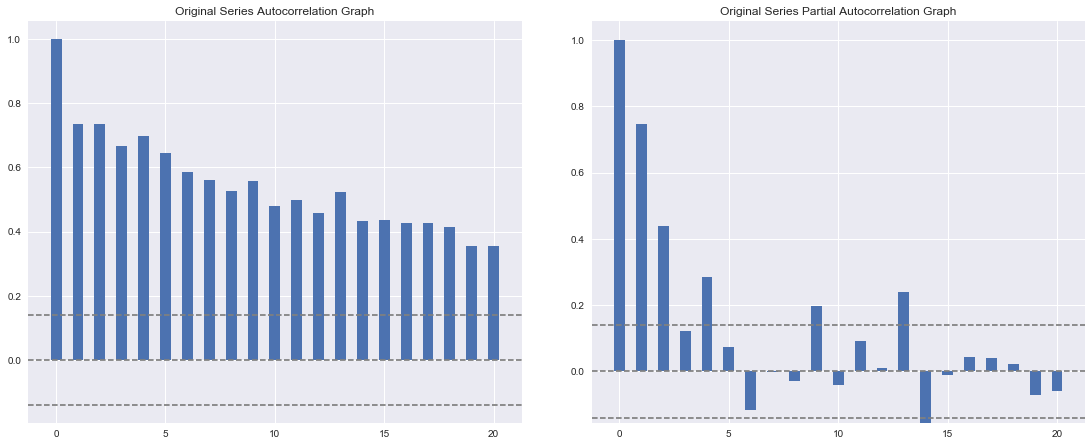

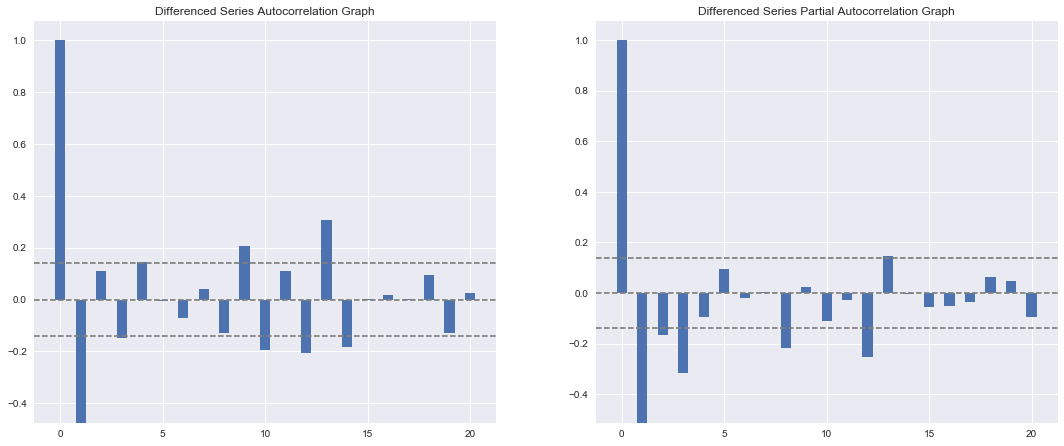

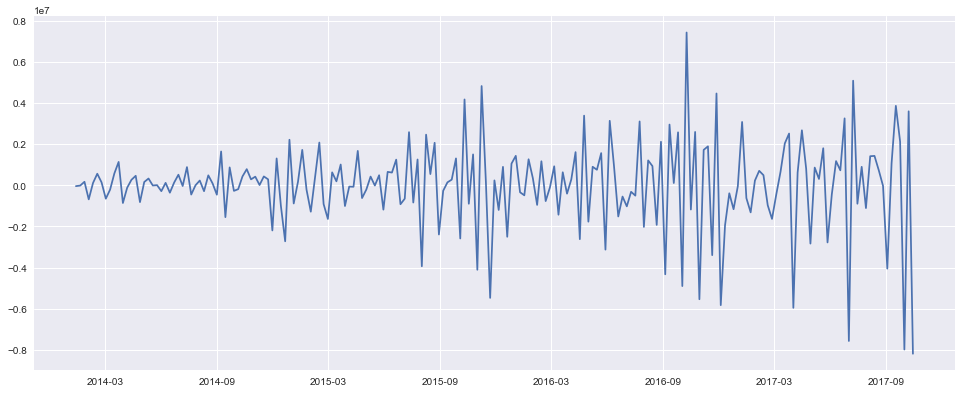

In [32]:
                        ############## Revenue Time series ACF and PACF Charts ####################

df_w = df_w[['Revenue']]
lag_acf = acf(df_w, nlags=20)
lag_pacf = pacf(df_w, nlags=20, method='ols')

#Plot ACF: 
plt.subplot(121) 
#plt.plot(lag_acf)
plt.bar(range(len(lag_acf)), lag_acf, width=1/2)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_w)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_w)),linestyle='--',color='gray')
plt.title('Original Series Autocorrelation Graph')
#Plot PACF:
plt.subplot(122)
#plt.plot(lag_pacf)
plt.bar(range(len(lag_pacf)), lag_pacf, width=1/2)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_w)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_w)),linestyle='--',color='gray')
plt.title('Original Series Partial Autocorrelation Graph')
plt.tight_layout()
fig = plt.gcf()
fig.set_size_inches(16.5, 6.5)
plt.show()

#df_w1_diff = df_w.diff(periods=1,axis=0) #pd.rolling_mean(df_w,1)
#df_w1_diff  = df_w1_diff[1:]
df_w_diff = df_w.diff(periods=1,axis=0) #pd.rolling_mean(df_w,1)
df_w_diff  = df_w_diff[1:]
lag_acf = acf(df_w_diff, nlags=20)
lag_pacf = pacf(df_w_diff, nlags=20, method='ols')
#Plot ACF: 
plt.subplot(121) 
#plt.plot(lag_acf)
plt.bar(range(len(lag_acf)), lag_acf, width=1/2)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_w_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_w_diff)),linestyle='--',color='gray')
plt.title('Differenced Series Autocorrelation Graph')
#Plot PACF:
plt.subplot(122)
#plt.plot(lag_pacf)
plt.bar(range(len(lag_pacf)), lag_pacf, width=1/2)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_w_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_w_diff)),linestyle='--',color='gray')
plt.title('Differenced Series Partial Autocorrelation Graph')
plt.tight_layout()
fig = plt.gcf()
fig.set_size_inches(16.5, 6.5)
plt.show()

plt.plot(df_w_diff,label='De-Trend')
fig = plt.gcf()
fig.set_size_inches(16.5, 6.5)
plt.show()


In [33]:
       #################### Looking at charts above we can create a differenced AR model of order 1,2,3  ###################

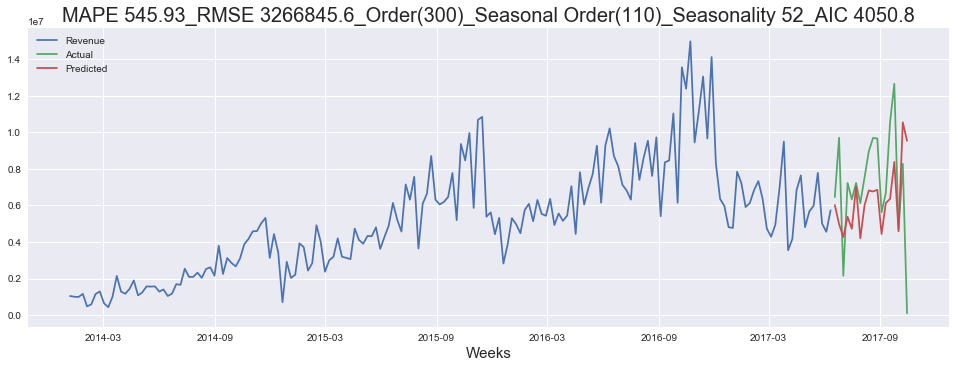

In [34]:
                                     ############### Run SARIMA Model ###################
train = df_w['Revenue'][0:-18]
test = df_w['Revenue'][len(train):]

p =3
d= 0
q = 0
pp = 1
dd = 1
qq = 0
z = 52
aic = 'null'

amape = 99
af = []

try:
    model = smt.SARIMAX(train, exog=None, order=(p, d, q), seasonal_order=(pp,dd,qq,z),trend = 'n').fit()
    aic = model.aic
    aic = round(aic,2)
    pred = model.get_forecast(len(test))
    fcst = pred.predicted_mean
    fcst.index = test.index
    mapelist = []
    for i in range(len(fcst)):
                    mapelist.insert(i, (np.absolute(test[i] - fcst[i])) / test[i])
    mape = np.mean(mapelist) * 100
    mape = round(mape,2)
except:
    mape = 9999
    pass

amape = mape
sap  = p
sad = d
saq = q
app = pp
add = dd
aqq = qq
az = z
af= fcst
mse = mean_squared_error(test, af)
rmse = np.sqrt(mse)
rmse = round(rmse,1)

plt.plot(train)
plt.plot(test,label='Actual')
plt.plot(af,label='Predicted')
fig = plt.gcf()
fig.set_size_inches(16.5, 5.5)
plt.title("MAPE "+str(amape)+"_"+"RMSE "+str(rmse)+"_"+"Order"+"("+str(sap)+str(sad)+str(saq)+")"+"_"+"Seasonal Order"
          +"("+str(app)+str(add)+str(aqq)+")"+"_"+"Seasonality "+str(az)+"_"+"AIC "+str(aic) ,fontsize=20)
plt.legend(loc='upper left')
plt.xlabel('Weeks', fontsize=15)
plt.show()

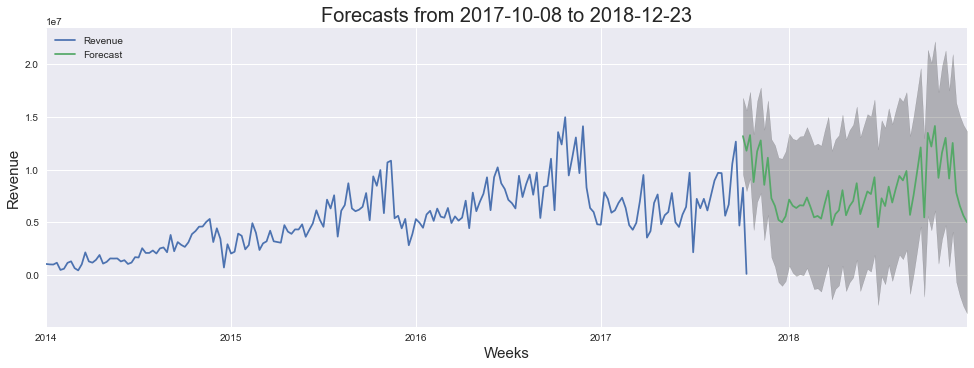

In [37]:
model = smt.SARIMAX(df_w[:-2], exog=None, order=(sap, sad, saq), seasonal_order=(app,add,aqq,az)).fit()
pred = model.get_forecast(64)
cf = pred.conf_int(alpha=0.05)
ax = df_w.plot(label='observed', figsize=(16.5, 5.5))
pred.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(cf.index, cf.iloc[:, 0],cf.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Weeks',fontsize = 15)
ax.set_ylabel('Revenue',fontsize = 15)
plt.legend(loc='upper left')
plt.title("Forecasts from "+str(cf.index[0]).split(' ')[0]+" to "+str(cf.index[-1]).split(' ')[0],fontsize = 20)
plt.show()

In [38]:
fcst = pred.conf_int(alpha=0.05)
fcst['Forecast'] = pred.predicted_mean
fcst = fcst.round(1)
forecast = pd.DataFrame()
forecast['Lower Revenue'] = fcst.apply(lambda x: "{:,}".format(x['lower Revenue']), axis=1)
forecast['Upper Revenue'] = fcst.apply(lambda x: "{:,}".format(x['upper Revenue']), axis=1)
forecast['Forecast'] = fcst.apply(lambda x: "{:,}".format(x['Forecast']), axis=1)
forecast

,Lower Revenue,Upper Revenue,Forecast
2017-10-08,"9,548,682.1","16,828,103.2","13,188,392.6"
2017-10-15,"7,962,823.7","15,640,234.8","11,801,529.2"
2017-10-22,"9,174,478.4","17,396,888.6","13,285,683.5"
2017-10-29,"4,265,041.3","13,377,773.7","8,821,407.5"
2017-11-05,"6,960,630.0","16,530,881.1","11,745,755.5"
2017-11-12,"7,763,206.5","17,801,303.8","12,782,255.2"
2017-11-19,"3,305,750.8","13,803,454.6","8,554,602.7"
2017-11-26,"5,702,972.9","16,570,173.2","11,136,573.1"
2017-12-03,"1,674,497.3","12,888,322.4","7,281,409.9"
2017-12-10,"790,837.1","12,322,493.7","6,556,665.4"
